# Caption Generation

This is a partial implementation of "Show and Tell: A Neural Image Caption Generator" (http://arxiv.org/abs/1411.4555), borrowing heavily from Andrej Karpathy's NeuralTalk (https://github.com/karpathy/neuraltalk)

### Output
This notebook samples from the trained network to generate captions given an input image.


### Prerequisites

To run this notebook, you'll need the trained GoogLeNet model, as well as the trained RNN model produced by the previous notebook

In [1]:
import sklearn
import numpy as np
import lasagne
import random
import skimage.transform

from lasagne.utils import floatX

import theano
import theano.tensor as T

import matplotlib.pyplot as plt
%matplotlib inline

import json
import pickle

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device gpu failed:
cublasCreate() returned this error 'the CUDA Runtime initialization failed'


MemoryError: Error allocating 40000 bytes of device memory (CNMEM_STATUS_NOT_INITIALIZED).

In [2]:
import googlenet

In [3]:
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['loss3/classifier']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

/data/anaconda3/envs/TheanoLasagne/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [4]:
model_param_values = pickle.load(open('blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

In [5]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

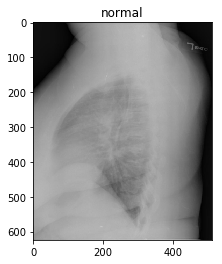

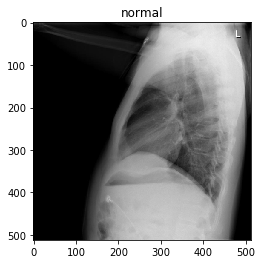

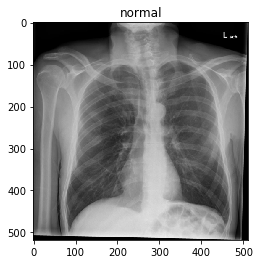

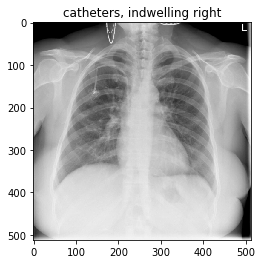

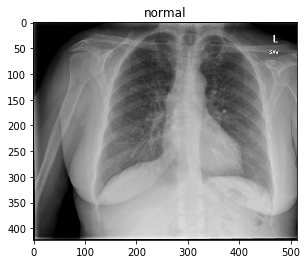

In [7]:
#im = plt.imread('/Users/Aydan/PycharmProjects/image_text_modelling/data/chestx/images/CXR3999_IM-2049-1001.jpg')
TEST_SIZE = 5

data = json.load(open("data/chestx/captions/captions.json"))["images"]
test_images = []

# return list of tuples (report, imageid) of test images
while len(test_images) < TEST_SIZE:
    item = random.choice(data)
    if item["split"] != "test":
        continue
    test_images.append((item["report"], item["imageid"]))

# plot images with corresponding reports
images = []
for im in test_images:
    fn = 'data/chestx/images/{}'.format('CXR' + im[1]) + '.png'
    try:
        plt.figure()
        plt.title(im[0])
        image = plt.imread(fn)
        images.append(image)
        plt.imshow(image)
    except IOError:
        print("Error plotting image")
        continue


In [8]:
prepd_images = []
for im in images:
    rawim, cnn_im = prep_image(im)
    prepd_images.append((rawim, cnn_im))

In [9]:
CLASSES = pickle.load(open('blvc_googlenet.pkl'))['synset words']
for im in prepd_images:
    p = get_cnn_features(im[1])
    print(CLASSES[p.argmax()])

spotlight, spot
spotlight, spot
spotlight, spot
spotlight, spot
spotlight, spot


In [10]:
SEQUENCE_LENGTH = 32
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
BATCH_SIZE = 1
CNN_FEATURE_SIZE = 1000
EMBEDDING_SIZE = 256

d = pickle.load(open('lstm_chestx_trained.pkl'))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']

In [11]:
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])
l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [12]:
lasagne.layers.set_all_param_values(l_out, d['param values'])

TypeError: ('CudaNdarrayType(float32, matrix), with dtype float32, cannot store a value of dtype float64 without risking loss of precision.If you do not mind, please cast your data to float32.', array([[ 0.29582674, -0.01610733,  0.19817156, ..., -0.3600139 ,
         0.08538631,  0.09869104],
       [-0.14746904,  0.18977626, -0.06473267, ...,  0.20579127,
         0.03405057, -0.10576139],
       [ 0.06457792,  0.02842416, -0.01443854, ...,  0.05781085,
        -0.06672832, -0.01172189],
       ..., 
       [ 0.04017361, -0.13825063, -0.19148902, ...,  0.13973056,
        -0.12579384,  0.01590474],
       [-0.40291611,  0.15756233,  0.18404546, ...,  0.2577467 ,
         0.16925203, -0.05692165],
       [-0.02130997,  0.08248701,  0.05902282, ...,  0.01794319,
         0.01068284, -0.06071974]]), 'Container name "W"')

In [38]:
x_cnn_sym = T.matrix()
x_sentence_sym = T.imatrix()

output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

f = theano.function([x_cnn_sym, x_sentence_sym], output)

In [39]:
def predict(x_cnn):
    x_sentence = np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32')
    words = []
    i = 0
    while True:
        i += 1
        p0 = f(x_cnn, x_sentence)
        pa = p0.argmax(-1)
        tok = pa[0][i]
        word = index_to_word[tok]
        if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
            return ' '.join(words)
        else:
            x_sentence[0][i] = tok
            if word != '#START#':
                words.append(word)

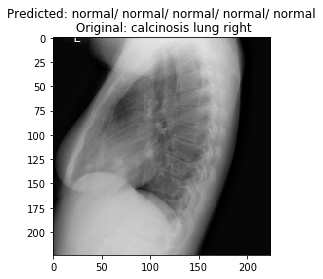

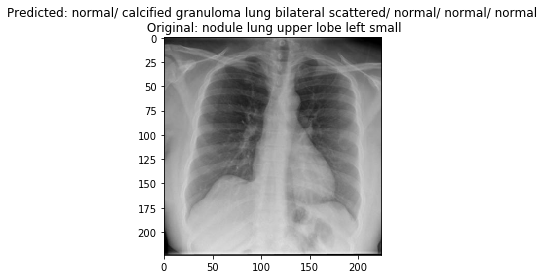

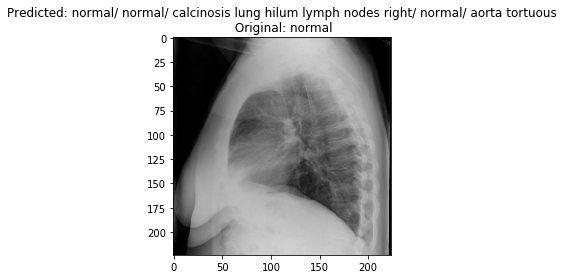

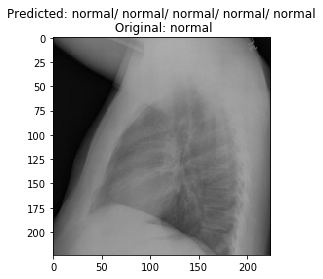

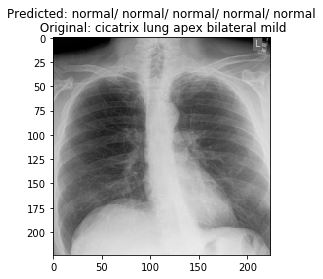

In [40]:
# Sample some predictions
prepd_images_arr = np.array(prepd_images)
test_images_arr = np.array(test_images)
for i in range(len(prepd_images_arr)):
    x_cnn = get_cnn_features(prepd_images_arr[i,1])
    predictions = []
    for _ in range(5):
        predictions.append(predict(x_cnn))
    plt.figure()
    plt.imshow(prepd_images_arr[i,0])
    plt.title("Predicted: " + "/ ".join(predictions) + "\n Original: " + test_images_arr[i,0])